In [ ]:
import kagglehub

# Download the dataset from Kaggle
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/maharshipandya/-spotify-tracks-dataset/versions/1


In [ ]:
!pip install category_encoders

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from category_encoders import BinaryEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

# Load data
file_path = f"{path}/dataset.csv"
data = pd.read_csv(file_path)

# Clean data by dropping null track names
print("Null track names before cleaning:", data['track_name'].isnull().sum())
data = data.dropna(subset=['track_name'])
print("Null track names after cleaning:", data['track_name'].isnull().sum())

# Strip whitespace from track_name to avoid duplicates caused by trailing spaces
data['track_name'] = data['track_name'].str.strip()

# Remove duplicates by track name
data = data.drop_duplicates(subset=['track_name'], keep='first')

# Replace infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop remaining null rows
data.dropna(inplace=True)

data.head()

Null track names before cleaning: 1
Null track names after cleaning: 0


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [ ]:
# Sample data for efficiency
sampled_data = data.sample(n=10000, random_state=463)  # Adjust as needed
print("Sampled data head:")
sampled_data.head()

Sampled data head:


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
99602,99602,4wPKUEm0EOoyUiFtI6mz1a,Stephen Sanchez,Lady by the Sea,Lady by the Sea,58,182983,False,0.439,0.503,...,-10.029,1,0.0281,0.284000,0.000056,0.1520,0.519,186.010,3,singer-songwriter
22160,22160,7IDQX9EUgMNQTgYcZSpO1d,Opeth,Blackwater Park,Blackwater Park,42,731306,False,0.109,0.854,...,-6.758,1,0.0871,0.000381,0.228000,0.1970,0.134,79.958,4,death-metal
21289,21289,4sHvKJc3qxiBuNTag8RiLq,Shamanes Crew,Reden-Zion,Se Ve Sola,39,189121,False,0.519,0.860,...,-5.475,1,0.3050,0.070100,0.000000,0.3870,0.948,219.571,4,dancehall
90443,90443,6NPTmYw2yMu0Oz0IJkoxeR,Los Tukas,10 de Colección,Mis Noches Te Recuerdan,33,134400,False,0.643,0.574,...,-5.427,1,0.0350,0.583000,0.000000,0.0492,0.845,108.002,4,rock-n-roll
37005,37005,5yY7mLBGMrTvG1VldsiWEP,Anitta,Am I Ready - Pop Night Out,Boys Don't Cry,2,135046,False,0.594,0.874,...,-3.598,1,0.0387,0.001660,0.000000,0.1480,0.646,164.163,4,funk


In [ ]:
print(sampled_data['track_name'].describe())
print("Missing values in sampled_data before final cleaning:")
print(sampled_data.isnull().sum())

count               10000
unique              10000
top       Lady by the Sea
freq                    1
Name: track_name, dtype: object
Missing values in sampled_data before final cleaning:
Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


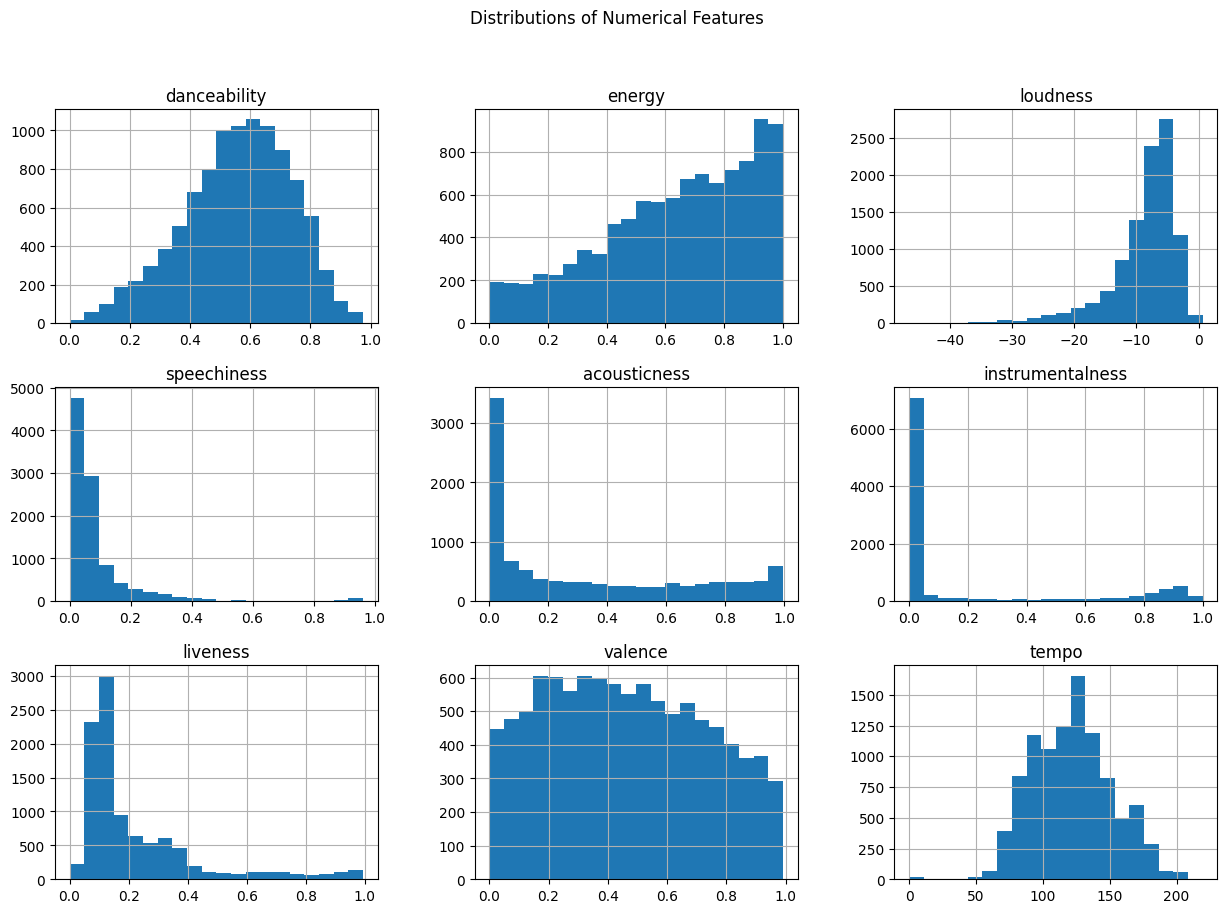

In [ ]:
import matplotlib.pyplot as plt

quant_features = ['danceability', 'energy', 'loudness', 'speechiness',
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

sampled_data[quant_features].hist(bins=20, figsize=(15, 10))
plt.suptitle("Distributions of Numerical Features")
plt.show()

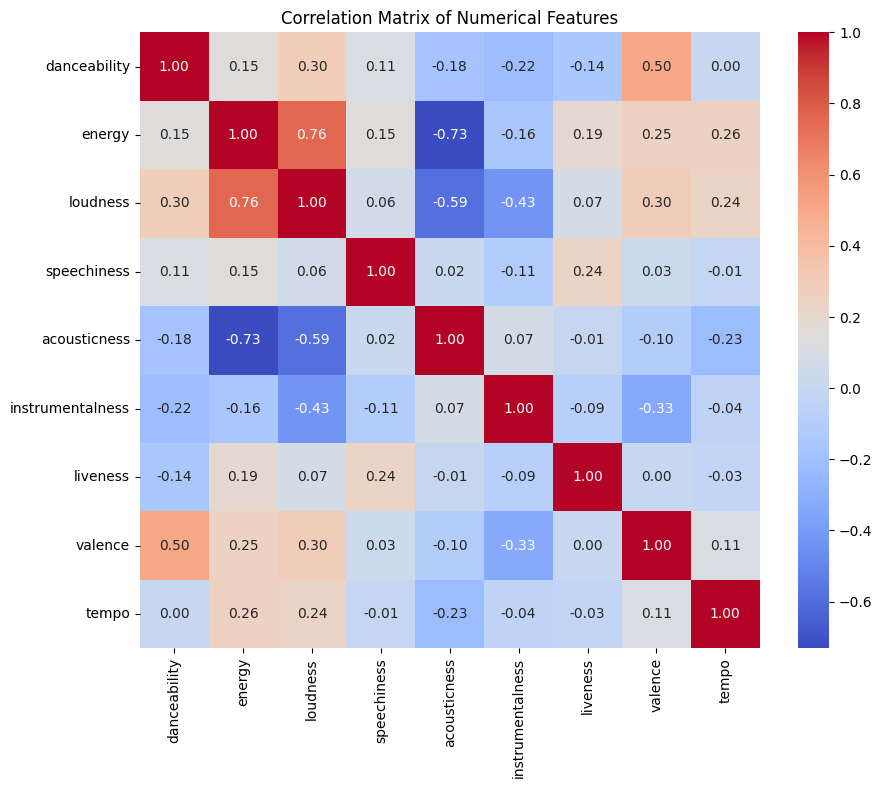

In [ ]:
import seaborn as sns

corr_matrix = sampled_data[quant_features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

quant_features = ['danceability', 'energy', 'loudness', 'speechiness',
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Apply Quantile Transformer to reduce skewness in skewed features like 'speechiness', 'acousticness', 'instrumentalness', 'liveness'
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)
skewed_features = ['speechiness', 'acousticness', 'instrumentalness', 'liveness']

sampled_data[skewed_features] = quantile_transformer.fit_transform(sampled_data[skewed_features])

# Use min max scaling to ensure all features are on the same scale (Will help later for KNN)
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
sampled_data[quant_features] = minmax_scaler.fit_transform(sampled_data[quant_features])

# Apply Binary Encoding to the 'track_genre' column
if 'track_genre' in sampled_data.columns:
    encoder = BinaryEncoder(cols=['track_genre'])
    genre_encoded = encoder.fit_transform(sampled_data['track_genre'])
    sampled_data = pd.concat([sampled_data, genre_encoded], axis=1)

if 'track_genre' in sampled_data.columns:
    binary_columns = genre_encoded.columns.tolist()
    features_columns = quant_features + binary_columns
else:
    features_columns = quant_features

features = sampled_data[features_columns]

In [ ]:
# Remove energy as it is strongly correlated with loudness (0.76) and moderately with acousticness (-0.74)
if 'energy' in sampled_data.columns:
    sampled_data.drop(columns=['energy'], inplace=True)
    quant_features.remove('energy')

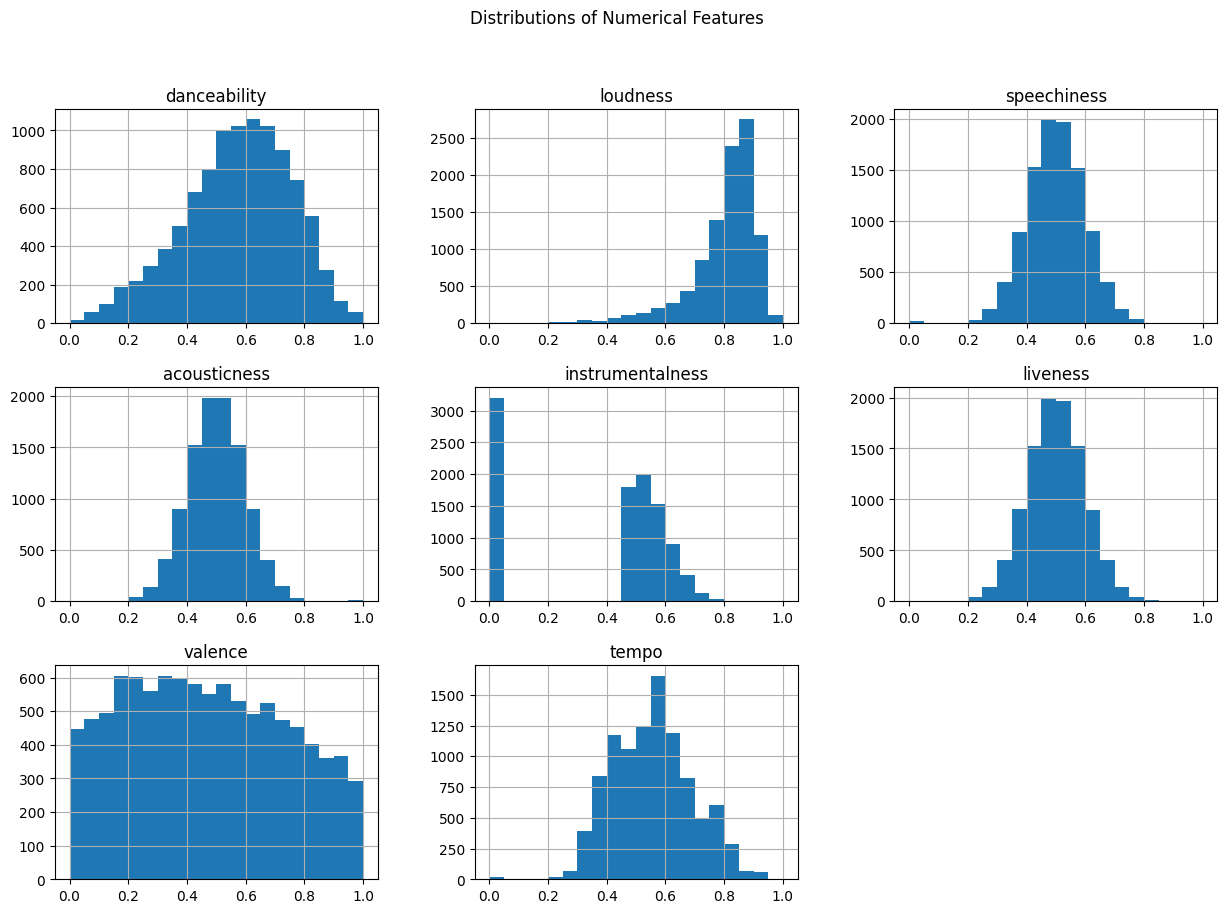

In [ ]:
# Replotting to show the new distibutions of all numerical features

sampled_data[quant_features].hist(bins=20, figsize=(15, 10))
plt.suptitle("Distributions of Numerical Features")
plt.show()

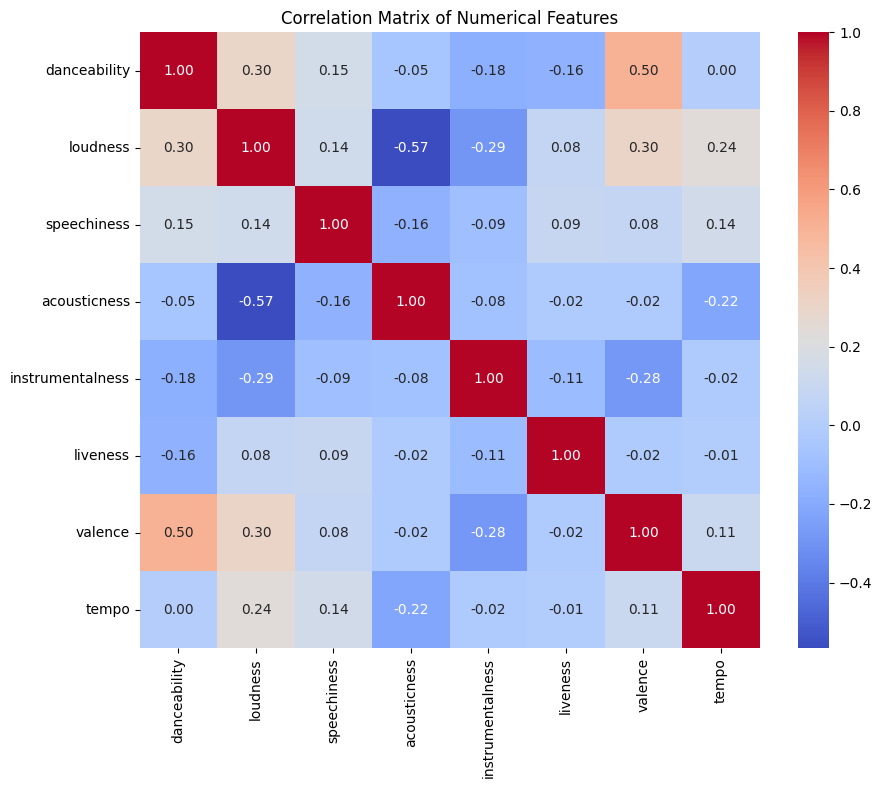

In [ ]:
# Replotting the heatmap to show resulting the new correlation matrix

corr_matrix = sampled_data[quant_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [ ]:
conn = sqlite3.connect('spotify_songs.db')
cursor = conn.cursor()

# Drop table if it already exists
cursor.execute("DROP TABLE IF EXISTS songs;")
conn.commit()

binary_columns_schema = ", ".join([f"{col} INTEGER" for col in binary_columns]) if binary_columns else ""
binary_columns_schema_clause = f", {binary_columns_schema}" if binary_columns_schema else ""

create_table_query = f"""
CREATE TABLE songs (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    track_name TEXT NOT NULL,
    artists TEXT NOT NULL,
    track_genre TEXT,
    danceability REAL,
    loudness REAL,
    speechiness REAL,
    acousticness REAL,
    instrumentalness REAL,
    liveness REAL,
    valence REAL,
    tempo REAL
    {binary_columns_schema_clause}
)
"""
cursor.execute(create_table_query)
conn.commit()

insert_query = f"""
INSERT INTO songs (track_name, artists, track_genre, danceability, loudness,
speechiness, acousticness, instrumentalness, liveness, valence, tempo
"""
if binary_columns:
    insert_query += f", {', '.join(binary_columns)}"
insert_query += ") VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?"
if binary_columns:
    insert_query += ", " + ", ".join(["?"] * len(binary_columns))
insert_query += ")"

# Insert  data into the songs table
for _, row in sampled_data.iterrows():
    values = [
        row['track_name'], row['artists'], row.get('track_genre', None),
        row['danceability'], row['loudness'], row['speechiness'], row['acousticness'],
        row['instrumentalness'], row['liveness'], row['valence'], row['tempo']
    ]
    if binary_columns:
        values.extend(row[binary_columns].values.tolist())
    cursor.execute(insert_query, values)

conn.commit()
conn.close()

In [ ]:
def get_all_songs():
    conn = sqlite3.connect('spotify_songs.db')
    cursor = conn.cursor()
    binary_select = f", {', '.join(binary_columns)}" if binary_columns else ""
    cursor.execute(f"""
    SELECT id, track_name, artists, danceability, loudness, speechiness, acousticness,
           instrumentalness, liveness, valence, tempo {binary_select}
    FROM songs
    """)
    results = cursor.fetchall()
    conn.close()

    songs = []
    features_list = []
    for row in results:
        songs.append({'id': row[0], 'track_name': row[1], 'artists': row[2]})
        features_list.append(row[3:])
    return songs, np.array(features_list)

In [ ]:
def get_song_features(song_name):
    conn = sqlite3.connect('spotify_songs.db')
    cursor = conn.cursor()
    binary_select = f", {', '.join(binary_columns)}" if binary_columns else ""
    cursor.execute(f"""
    SELECT id, danceability, loudness, speechiness, acousticness, instrumentalness, liveness,
           valence, tempo {binary_select}
    FROM songs
    WHERE track_name = ?
    """, (song_name,))
    result = cursor.fetchone()
    conn.close()

    if result:
        return result[0], np.array(result[1:])
    else:
        # Song not in set
        return None, None

In [ ]:
def recommend_songs_knn(song_name, top_n=5):
    songs, features = get_all_songs()
    input_id, input_features = get_song_features(song_name)

    if input_features is None:
        return []

    # Build KNN model
    knn_model = NearestNeighbors(n_neighbors=top_n + 1, metric='cosine')  # Add 1 to skip the song itself
    knn_model.fit(features)

    distances, indices = knn_model.kneighbors([input_features])

    # Exclude the input song
    recommendations = [songs[i] for i in indices[0] if songs[i]['id'] != input_id][:top_n]

    return recommendations

In [ ]:
from sklearn.metrics import mean_squared_error

def evaluate_mse(test_data, k=5):
    actual_scores = []
    predicted_scores = []

    for track_name in test_data['track_name']:
        recommendations = recommend_songs_knn(track_name, top_n=k)
        for rec in recommendations:
            recommended_features = get_song_features(rec['track_name'])[1]
            input_features = get_song_features(track_name)[1]

            if recommended_features is not None and input_features is not None:
                # Calculate predicted similarity score
                distance = np.linalg.norm(recommended_features - input_features)
                predicted_score = 1 / (1 + distance)  # Similarity = inverse of distance

                # Append simulated actual and predicted scores
                actual_scores.append(1)  # Simulate "ideal" score as 1
                predicted_scores.append(predicted_score)

    mse = mean_squared_error(actual_scores, predicted_scores)
    print(f"Mean Squared Error (MSE): {mse}")
    return mse

In [ ]:
def hit_rate_at_k(test_data, k=5):
    # Without a ground-truth relevance set, we just check if recommended tracks are also in test_data
    test_track_names = set(test_data['track_name'])
    hits = 0
    for track_name in test_data['track_name']:
        recommended_tracks = recommend_songs_knn(track_name, top_n=k)
        # Check if any recommended track is in test_data and not the same track
        if any((rec['track_name'] in test_track_names) and (rec['track_name'] != track_name)
               for rec in recommended_tracks):
            hits += 1
    hit_rate = hits / len(test_data)
    print(f"Hit Rate @ {k}: {hit_rate}")
    return hit_rate

In [ ]:
# Test
test_song = sampled_data.iloc[2999]['track_name']
recommendations = recommend_songs_knn(test_song)
print(f"Recommendations for '{test_song}':\n")
for rec in recommendations:
    print(f"{rec['track_name']} by {rec['artists']}\n")

Recommendations for 'Symphony No. 7 in D, K.45: 4. (Allegro)':

12 Variations in C Major on "Ah, vous dirai-je Maman", K. 265: 8. Variation VII by Wolfgang Amadeus Mozart;Danielle Laval

Six German Dances, K.571: No. 5 in B Flat Major by Wolfgang Amadeus Mozart;Wiener Mozart Ensemble;Willi Boskovsky

Indrayani Kathi by Bhimsen Joshi

Carnaval, Op. 9: No. 20, Pause (Live in Japan, 2022) by Robert Schumann;Pavel Nersessian

Six German Dances, K.571: No. 5 in B flat by Wolfgang Amadeus Mozart;Sarband;Vladimir Ivanoff;Concerto Köln;Werner Ehrhardt



In [ ]:
test_data = sampled_data.sample(n=50, random_state=42)  # Simulate a test set
evaluate_mse(test_data, k=5)
hit_rate_at_k(test_data, k=5)

Mean Squared Error (MSE): 0.033159887681953604
Hit Rate @ 5: 0.04


0.04